In [11]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Outliers detection
from sklearn.ensemble import IsolationForest

# Train/Test splitting
from sklearn.model_selection import train_test_split

# Lasso regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, normalize

# Neural networks
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

# Error
from sklearn.metrics import r2_score

In [12]:
#importing the data
X = pd.read_csv('X_train.csv', float_precision='high').drop('id', axis=1)
y = pd.read_csv('y_train.csv', float_precision='high').drop('id', axis=1)

# replacing the missing values with the median of that column
X = X.fillna(X.median())

# Isolation Forest

In [13]:
# creating the model
clf = IsolationForest(max_samples=100, random_state = 69420, contamination='auto')

# getting the outliers
preds = clf.fit_predict(X)

# removing outliers
X = X[preds==1]
y = y[preds==1]

# Splitting the dataset

In [14]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Choosing the most correlated features

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


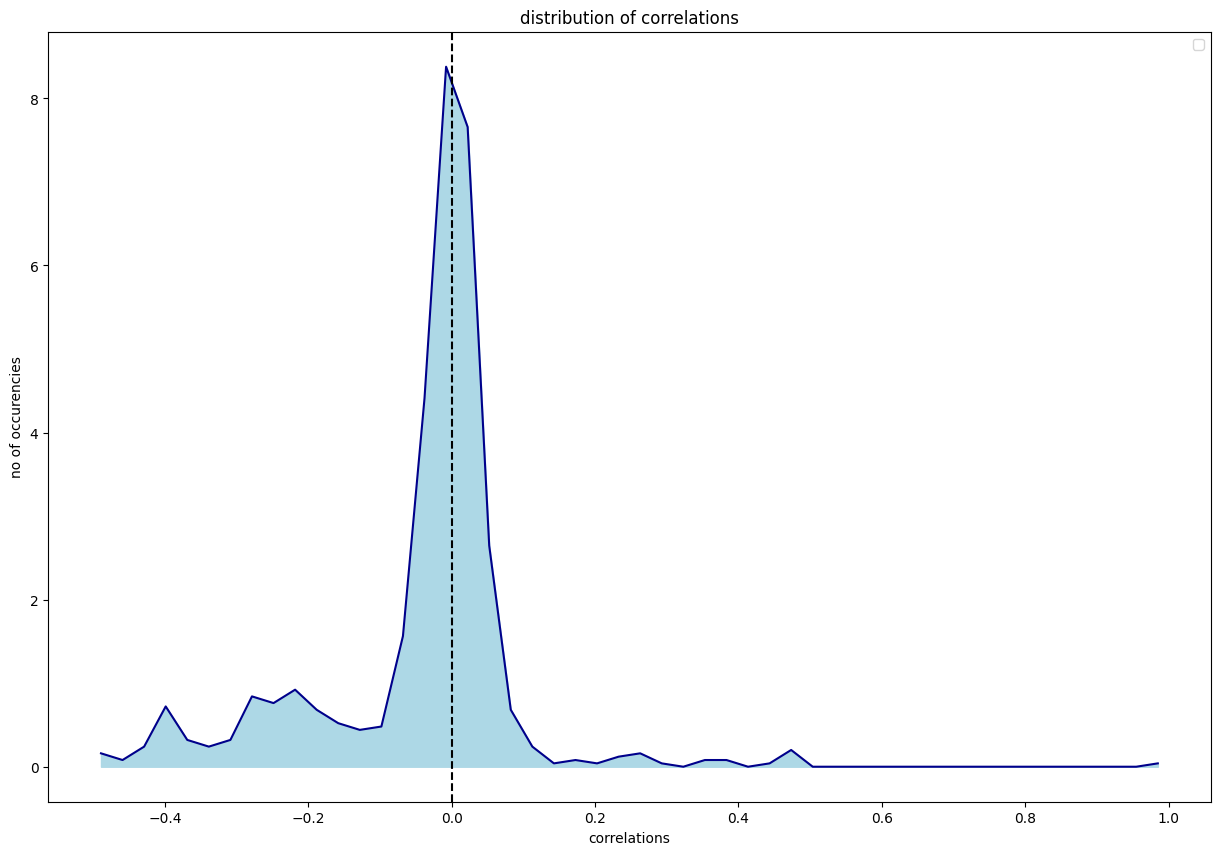

In [15]:
full_data = X_train.copy()
full_data['y'] = y_train

correlations = full_data.corr().y.dropna()

# plotting the distribution of feature importance
nbins = 50

n, bins = np.histogram(correlations.values, nbins, density=1)

pdfx, pdfy = np.zeros(n.size), np.zeros(n.size)

for k in range(n.size):
    pdfx[k], pdfy[k] = 0.5*(bins[k] + bins[k+1]), n[k]

plt.figure(figsize=(15,10))
plt.title('distribution of correlations')
plt.ylabel('no of occurencies')
plt.xlabel('correlations')

plt.plot(pdfx, pdfy, color = 'darkblue')
plt.fill_between(pdfx, pdfy, color = 'lightblue')

plt.axvline(x=0, color='k', linestyle='--')

plt.legend()
plt.show()

del full_data

In [16]:
# saving the correlated features
correlated_features_1 = correlations[((correlations > 0.1) | (correlations < -0.1)) & 
                                      (correlations.index != 'y')].index

correlated_features_2 = correlations[((correlations > 0.1) | (correlations < -0.15)) & 
                                      (correlations.index != 'y')].index

correlated_features_3 = correlations[((correlations > 0.15) | (correlations < -0.1)) & 
                                      (correlations.index != 'y')].index

correlated_features_4 = correlations[((correlations > 0.15) | (correlations < -0.15)) & 
                                      (correlations.index != 'y')].index

# Lasso regression

In [17]:
def apply_lasso_regression(degree, X_train_param, y_train_param, X_test_param):
    
    # creating regression model
    model = Lasso(alpha=0.0001)
    
    # Generates a new feature matrix consisting of all polynomial combinations of the features with degree 
    # less than or equal to the specified degree. For example, if an input sample is two dimensional and of 
    # the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
    polynomial_features = PolynomialFeatures(degree)
    X_train_poly = polynomial_features.fit_transform(X_train_param)
    
    # fitting the train data
    model.fit(X_train_poly, y_train_param/100)
    
    # making predictions for test data
    X_test_poly = polynomial_features.fit_transform(X_test_param)
    y_pred = model.predict(X_test_poly)

    #calculating the accuracy
    score = r2_score(y_test, y_pred*100)
    
    print('The obtained r2 score is : ',score)
        
    return model

In [18]:
model = apply_lasso_regression(1, X_train, y_train, X_test)

The obtained r2 score is :  -1.0193162322336558


c:\Users\yarek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.375e-01, tolerance: 8.963e-04
  model = cd_fast.enet_coordinate_descent(


In [19]:
lasso_features_1 = X.columns[(np.abs(model.coef_) > 1e-5)[1:]]
lasso_features_2 = X.columns[(np.abs(model.coef_) > 1e-6)[1:]]
lasso_features_3 = X.columns[(np.abs(model.coef_) > 1e-7)[1:]]
lasso_features_4 = X.columns[(np.abs(model.coef_) > 1e-8)[1:]]

# Neural network

In [20]:
# Splitting The Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features_to_try = [correlated_features_1, correlated_features_2, correlated_features_3, correlated_features_4,
                   lasso_features_1, lasso_features_2, lasso_features_3, lasso_features_4]

scores = []

for features in features_to_try:
    # Normalizing the data

    # ----- Normalizing X values -----
    X_train_normalized = X_train[correlated_features_1]
    X_test_normalized = X_test[correlated_features_1]

    # Normalizing the X values
    X_train_normalized = (X_train_normalized - X_train_normalized.mean()) / X_train_normalized.std()
    X_test_normalized = (X_test_normalized - X_test_normalized.mean()) / X_test_normalized.std()

    # Making X numpy arrays
    X_train_normalized = X_train_normalized.values
    X_test_normalized = X_test_normalized.values

    # ----- Normalizing y values -----
    y_mean, y_std = y.mean()[0], y.std()[0]

    y_train_normalized = ((y_train - y_mean) / y_std).values
    
    # Fitting Neural Network
    
    n = X_train_normalized.shape[1]

    model = Sequential([Dense(n, activation='relu'),
                        Dense(1024, activation='relu'),
                        Dense(512, activation='relu'),
                        Dropout(0.1),
                        Dense(1024, activation='relu'),
                        Dense(1024, activation='relu'),
                        Dropout(0.1),
                        Dense(1024, activation='relu'),
                        Dropout(0.1),
                        Dense(512, activation='relu'),
                        Dense(256, activation='relu'),
                        Dense(1)])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(X_train_normalized, y_train_normalized, epochs=30)
    
    # Predicting values
    y_pred = model.predict(X_test_normalized)
    y_pred = y_pred*y_std + y_mean
    
    # Saving the score
    score = r2_score(y_test, y_pred)
    scores.append(score)

Epoch 1/30


C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\509753620.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 21ms/step - loss: 0.7238
Epoch 2/30
30/30 [==============================] - 1s 22ms/step - loss: 0.5979
Epoch 3/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5014
Epoch 4/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4366
Epoch 5/30
30/30 [==============================] - 1s 22ms/step - loss: 0.4208
Epoch 6/30
30/30 [==============================] - 1s 22ms/step - loss: 0.4177
Epoch 7/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3539
Epoch 8/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3340
Epoch 9/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2834
Epoch 10/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3173
Epoch 11/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2815
Epoch 12/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2735
Epoch 13/30
30/30 [=============================

C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\509753620.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 21ms/step - loss: 0.6980
Epoch 2/30
30/30 [==============================] - 1s 21ms/step - loss: 0.5615
Epoch 3/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5253
Epoch 4/30
30/30 [==============================] - 1s 22ms/step - loss: 0.4853
Epoch 5/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4303
Epoch 6/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3904
Epoch 7/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3263
Epoch 8/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3216
Epoch 9/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3206
Epoch 10/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2924
Epoch 11/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2810
Epoch 12/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2373
Epoch 13/30
30/30 [=============================

C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\509753620.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 21ms/step - loss: 0.7351
Epoch 2/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5901
Epoch 3/30
30/30 [==============================] - 1s 22ms/step - loss: 0.5237
Epoch 4/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4954
Epoch 5/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4351
Epoch 6/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4029
Epoch 7/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4239
Epoch 8/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3817
Epoch 9/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3053
Epoch 10/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2964
Epoch 11/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2648
Epoch 12/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2623
Epoch 13/30
30/30 [=============================

C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\509753620.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 22ms/step - loss: 0.6552
Epoch 2/30
30/30 [==============================] - 1s 22ms/step - loss: 0.5263
Epoch 3/30
30/30 [==============================] - 1s 22ms/step - loss: 0.5161
Epoch 4/30
30/30 [==============================] - 1s 22ms/step - loss: 0.4644
Epoch 5/30
30/30 [==============================] - 1s 22ms/step - loss: 0.4399
Epoch 6/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3803
Epoch 7/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3535
Epoch 8/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3175
Epoch 9/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3022
Epoch 10/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3087
Epoch 11/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2849
Epoch 12/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2700
Epoch 13/30
30/30 [=============================

C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\509753620.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 22ms/step - loss: 0.6674
Epoch 2/30
30/30 [==============================] - 1s 24ms/step - loss: 0.5907
Epoch 3/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5050
Epoch 4/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4588
Epoch 5/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4090
Epoch 6/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3818
Epoch 7/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3653
Epoch 8/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3268
Epoch 9/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3759
Epoch 10/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3294
Epoch 11/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2967
Epoch 12/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2592
Epoch 13/30
30/30 [=============================

C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\509753620.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 22ms/step - loss: 0.6801
Epoch 2/30
30/30 [==============================] - 1s 22ms/step - loss: 0.5499
Epoch 3/30
30/30 [==============================] - 1s 22ms/step - loss: 0.5139
Epoch 4/30
30/30 [==============================] - 1s 22ms/step - loss: 0.5380
Epoch 5/30
30/30 [==============================] - 1s 22ms/step - loss: 0.4616
Epoch 6/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4113
Epoch 7/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3627
Epoch 8/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3374
Epoch 9/30
30/30 [==============================] - 1s 22ms/step - loss: 0.3380
Epoch 10/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2942
Epoch 11/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2527
Epoch 12/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2436
Epoch 13/30
30/30 [=============================

C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\509753620.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 23ms/step - loss: 0.6509
Epoch 2/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5846
Epoch 3/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5230
Epoch 4/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4577
Epoch 5/30
30/30 [==============================] - 1s 22ms/step - loss: 0.4469
Epoch 6/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4307
Epoch 7/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3694
Epoch 8/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3435
Epoch 9/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3243
Epoch 10/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3229
Epoch 11/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3206
Epoch 12/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2697
Epoch 13/30
30/30 [=============================

C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\509753620.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 22ms/step - loss: 0.7076
Epoch 2/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5549
Epoch 3/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4736
Epoch 4/30
30/30 [==============================] - 1s 22ms/step - loss: 0.4777
Epoch 5/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3983
Epoch 6/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3808
Epoch 7/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3437
Epoch 8/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3145
Epoch 9/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3109
Epoch 10/30
30/30 [==============================] - 1s 22ms/step - loss: 0.2952
Epoch 11/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2591
Epoch 12/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2870
Epoch 13/30
30/30 [=============================

In [21]:
for i, score in enumerate(scores):
    print('The obtained r2 score when using {}-th features is: {}'.format(i,score))

The obtained r2 score when using 0-th features is: 0.44891324694350954
The obtained r2 score when using 1-th features is: 0.4386013720356109
The obtained r2 score when using 2-th features is: 0.4173542206445786
The obtained r2 score when using 3-th features is: 0.44569048300602687
The obtained r2 score when using 4-th features is: 0.41901845838303997
The obtained r2 score when using 5-th features is: 0.41145503096178804
The obtained r2 score when using 6-th features is: 0.43042161474295526
The obtained r2 score when using 7-th features is: 0.4297962349833605


In [22]:
# Splitting The Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalizing the data

# ----- Normalizing X values -----
X_train_normalized = X_train[correlated_features_1]
X_test_normalized = X_test[correlated_features_1]

# Normalizing the X values
X_train_normalized = (X_train_normalized - X_train_normalized.mean()) / X_train_normalized.std()
X_test_normalized = (X_test_normalized - X_test_normalized.mean()) / X_test_normalized.std()

# Making X numpy arrays
X_train_normalized = X_train_normalized.values
X_test_normalized = X_test_normalized.values

# ----- Normalizing y values -----
y_mean, y_std = y.mean()[0], y.std()[0]

y_train_normalized = ((y_train - y_mean) / y_std).values

# Fitting Neural Network

n = X_train_normalized.shape[1]

model = Sequential([Dense(n, activation='relu'),
                    Dense(1024, activation='relu'),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(1024, activation='relu'),
                    Dense(1024, activation='relu'),
                    Dropout(0.1),
                    Dense(1024, activation='relu'),
                    Dropout(0.1),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(1)])

model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(X_train_normalized, y_train_normalized, epochs=30)

Epoch 1/30


C:\Users\yarek\AppData\Local\Temp\ipykernel_26332\2785764194.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mean, y_std = y.mean()[0], y.std()[0]


30/30 [==============================] - 2s 22ms/step - loss: 0.6973
Epoch 2/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5898
Epoch 3/30
30/30 [==============================] - 1s 22ms/step - loss: 0.5125
Epoch 4/30
30/30 [==============================] - 1s 23ms/step - loss: 0.5046
Epoch 5/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4471
Epoch 6/30
30/30 [==============================] - 1s 23ms/step - loss: 0.4072
Epoch 7/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3655
Epoch 8/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3297
Epoch 9/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3390
Epoch 10/30
30/30 [==============================] - 1s 24ms/step - loss: 0.3015
Epoch 11/30
30/30 [==============================] - 1s 23ms/step - loss: 0.3164
Epoch 12/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2876
Epoch 13/30
30/30 [=============================

# making final predictions

In [23]:
X_final = pd.read_csv('X_test.csv', float_precision='high')

In [24]:
ids = X_final.id

In [25]:
X_final.head()

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,0.0,14655.540585,9917.388635,3368.691863,104367.124458,104.132894,95.412138,9222.286185,NaN,10054.751221,...,9153.072463,12039.009308,714.005017,105.651509,103.574436,2628.082823,2.766271,1553.285942,1037.998392,9762.400011
1,1.0,13875.822363,9955.163751,3118.195658,103577.269601,103.290975,86.916779,9625.725002,10592.011548,10234.818476,...,9915.292110,12579.041315,695.070183,106.900274,105.241730,2388.096545,NaN,1386.519117,1088.519466,11748.788738
2,2.0,14807.162495,10682.476988,3335.687716,106647.642610,109.481676,86.476353,9128.693785,10880.979240,10485.268796,...,9733.845509,11009.075093,663.093857,105.541065,101.875603,2097.004365,2.362592,1204.527342,1067.697534,12487.217965
3,3.0,12253.667985,9001.609788,2631.482012,91105.570966,108.741037,84.542046,9765.458299,10953.438053,10190.986014,...,11204.016625,9395.016940,656.018142,104.816602,107.213434,2035.045976,3.052844,794.341243,NaN,7931.828963
4,4.0,18925.988003,12161.366373,3724.006508,110262.565336,102.085795,107.920270,9494.243179,10684.550944,10074.187696,...,11093.701929,13876.039832,964.037692,104.557952,109.185247,2971.082813,2.571392,1207.265749,1013.661254,8241.962297


In [26]:
X_final = X_final.fillna(X_final.median()).drop('id', axis=1)

X_final_normalized = X_final[correlated_features_1]

# Normalizing the X values
X_final_normalized = (X_final_normalized - X_final_normalized.mean()) / X_final_normalized.std()

# Making X numpy arrays
X_final_normalized = X_final_normalized.values

In [27]:
y_final_pred = model.predict(X_final_normalized)
y_final_pred = y_final_pred*y_std + y_mean
y_final_pred = y_final_pred.reshape(len(y_final_pred))

25/25 [==============================] - 0s 5ms/step


In [28]:
y_final_pred = pd.concat([ids,pd.Series(y_final_pred)], keys = ['id','y'], axis=1)

In [29]:
y_final_pred.head()

,id,y
0,0.0,63.169296
1,1.0,73.881737
2,2.0,69.122620
3,3.0,79.541786
4,4.0,72.797653


In [30]:
y_final_pred.to_csv('task1.csv')